PLP-Python-COVID-19-Global-Data-Tracker-Project.

Loading and cleaning pandemic dataset...
Data loaded successfully!

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429435 entries, 0 to 429434
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    429435 non-null  object 
 1   continent                                   402910 non-null  object 
 2   location                                    429435 non-null  object 
 3   date                                        429435 non-null  object 
 4   total_cases                                 411804 non-null  float64
 5   new_cases                                   410159 non-null  float64
 6   new_cases_smoothed                          408929 non-null  float64
 7   total_deaths                                411804 non-null  float64
 8   new_deaths                                  410608 non-null  f

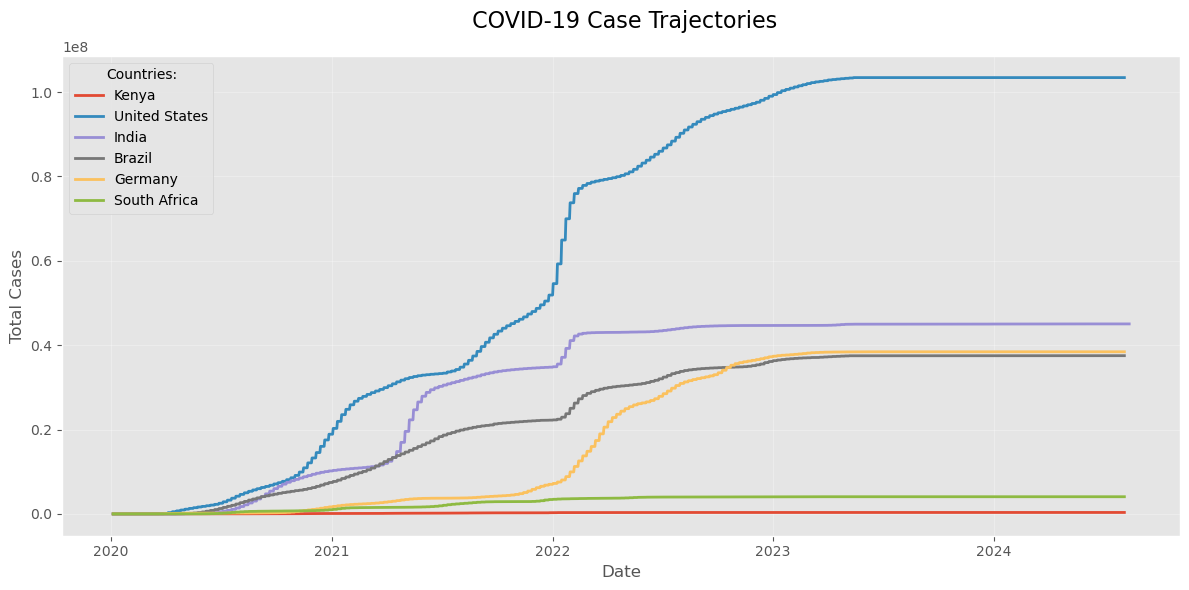

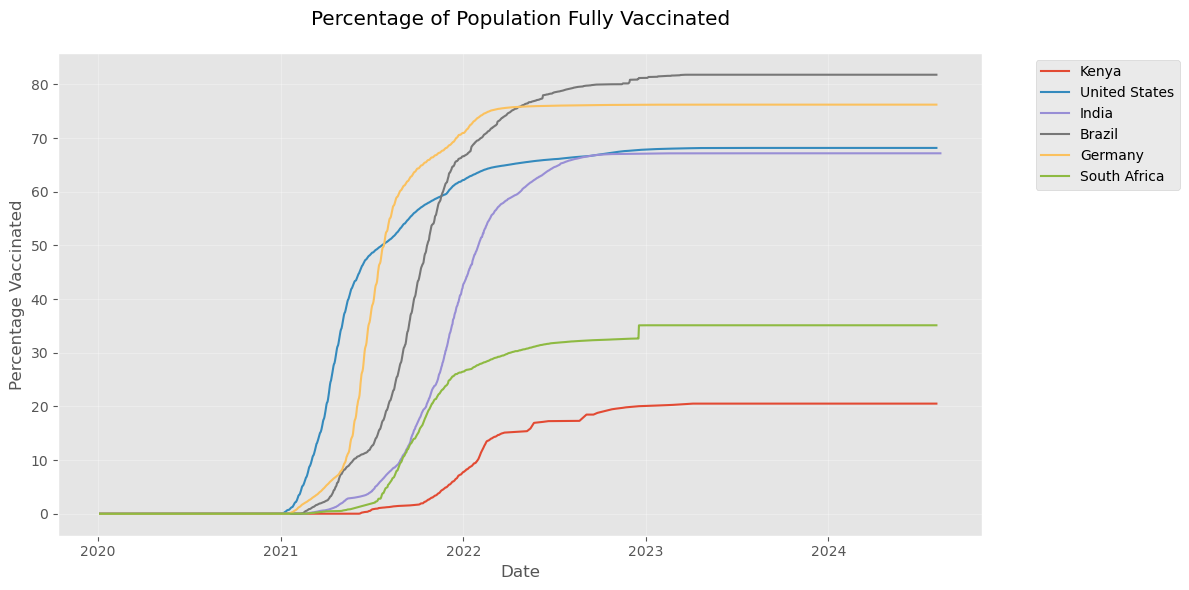

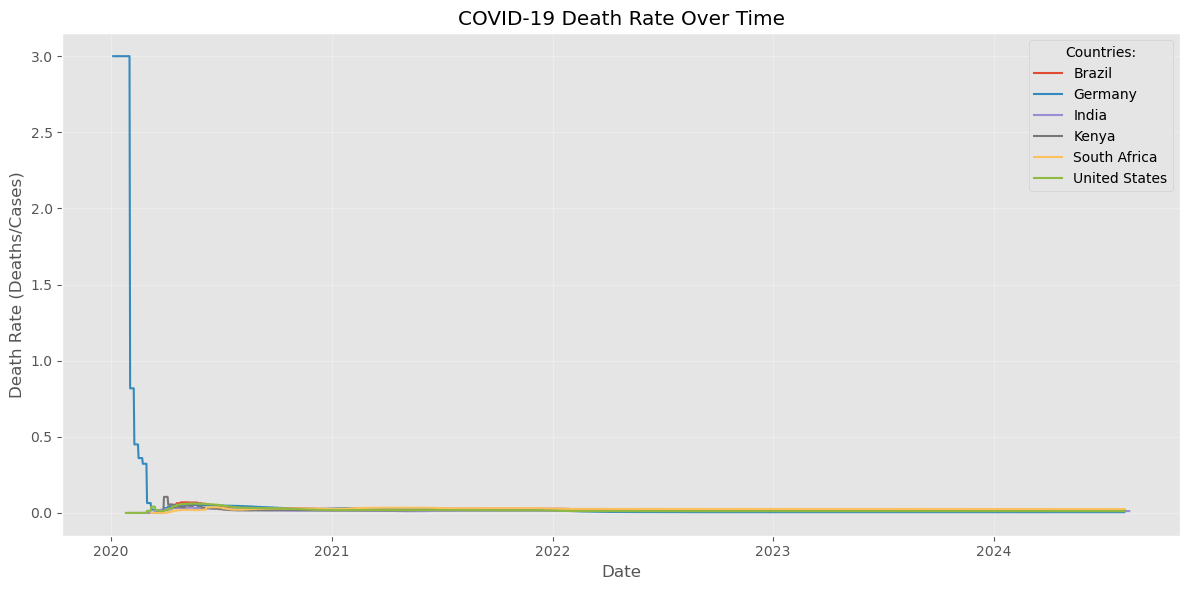

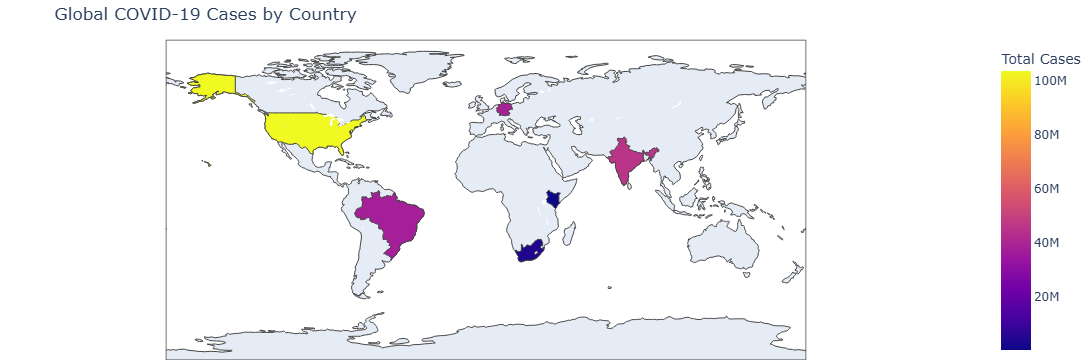


 Analysis complete!


In [6]:
# COVID-19 GLOBAL DATA ANALYSIS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# 1. DATA LOADING AND CLEANING
print("Loading and cleaning pandemic dataset...")

# Initialize empty dataframe
df = pd.DataFrame()

try:
    df = pd.read_csv('owid-covid-data.csv')
    print("Data loaded successfully!")
    
    # Initial exploration
    print("\nDataset Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())

    # Data preparation
    df['date'] = pd.to_datetime(df['date'])

    # Select countries of interest
    countries = ['Kenya', 'United States', 'India', 'Brazil', 'Germany', 'South Africa']
    df = df[df['location'].isin(countries)]

    # Select relevant columns and handle missing values
    cols = ['date', 'location', 'total_cases', 'new_cases', 'total_deaths', 
            'new_deaths', 'total_vaccinations', 'people_vaccinated',
            'people_fully_vaccinated', 'population', 'iso_code']

    df = df[cols].copy()

    # Interpolate missing numeric values
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = df.groupby('location')[numeric_cols].transform(lambda x: x.interpolate())
    df[numeric_cols] = df[numeric_cols].fillna(0)

    print("\n Data cleaned and ready for analysis!")
    # 2. VISUALIZATIONS
    print("\n Creating visualizations...")

    # Set style for matplotlib
    plt.style.use('ggplot')

    # A. Total Cases Over Time
    plt.figure(figsize=(12,6))
    for country in countries:
        country_data = df[df['location'] == country]
        plt.plot(country_data['date'], country_data['total_cases'], label=country, linewidth=2)

    plt.title(' COVID-19 Case Trajectories', pad=20, fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Total Cases')
    plt.legend(title='Countries:')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # B. Vaccination Progress
    plt.figure(figsize=(12,6))
    for country in countries:
        country_data = df[df['location'] == country].dropna(subset=['people_fully_vaccinated', 'population'])
        if not country_data.empty:
            plt.plot(country_data['date'], 
                    country_data['people_fully_vaccinated'] / country_data['population'] * 100, 
                    label=country)

    plt.title('Percentage of Population Fully Vaccinated', pad=20)
    plt.xlabel('Date')
    plt.ylabel('Percentage Vaccinated')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # C. Death Rate Analysis
    df['death_rate'] = df['total_deaths'] / df['total_cases']
    df['death_rate'] = df['death_rate'].replace([np.inf, -np.inf], 0)  # Handle division by zero

    plt.figure(figsize=(12,6))
    sns.lineplot(data=df, x='date', y='death_rate', hue='location')
    plt.title('COVID-19 Death Rate Over Time')
    plt.xlabel('Date')
    plt.ylabel('Death Rate (Deaths/Cases)')
    plt.legend(title='Countries:')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # D. Global Choropleth Map (using Plotly)
    latest = df.sort_values('date').groupby('location', as_index=False).last()

    if 'iso_code' in latest.columns:
        fig = px.choropleth(latest,
                           locations="iso_code",
                           color="total_cases",
                           hover_name="location",
                           hover_data=["total_deaths", "population"],
                           color_continuous_scale=px.colors.sequential.Plasma,
                           title="Global COVID-19 Cases by Country",
                           labels={'total_cases': 'Total Cases'})
        fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
        fig.show()
    else:
        print("Warning: ISO codes missing - choropleth map cannot be displayed")

except FileNotFoundError:
    print(" Error: File 'owid-covid-data.csv' not found. Please ensure:")
    print("1. The file exists in your current directory")
    print("2. The filename is spelled correctly")
    print("3. You've downloaded the dataset from Our World in Data")
except Exception as e:
    print(f" An unexpected error occurred: {str(e)}")
finally:
    print("\n Analysis complete!" if not df.empty else "\n Analysis incomplete due to errors")

